In [1]:
import random
import numpy.random as npr
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

initializing chromosome size

In [2]:
chromosome_size = 8
population_size = 100

function for generating a chromosome

In [3]:
def random_individual(size):
    return [random.randint(1, size) for _ in range(size)]

In [4]:
def get_max_fitness(chromosome_size):
  return int((chromosome_size*(chromosome_size-1))/2)

In [5]:
def fitness(individual):
    horizontal_collisions = sum([individual.count(queen) - 1 for queen in individual]) / 2
    n = len(individual)
    left_diagonal = [0] * 2 * n
    right_diagonal = [0] * 2 * n
    for i in range(n):
        left_diagonal[i + individual[i] - 1] += 1
        right_diagonal[len(individual) - i + individual[i] - 2] += 1
    diagonal_collisions = 0
    for i in range(2 * n - 1):
        counter = 0
        if left_diagonal[i] > 1:
            counter += left_diagonal[i] - 1
        if right_diagonal[i] > 1:
            counter += right_diagonal[i] - 1
        diagonal_collisions += counter / (n - abs(i - n + 1))
    return int(get_max_fitness(chromosome_size) - (horizontal_collisions + diagonal_collisions))

method to calculate selection probability of an individual

In [6]:
def probability(individual):
    return (fitness(individual) / get_max_fitness(chromosome_size))

selection probabilities

In [7]:
def random_pick(population, probabilities):
    populationWithProbabilty = zip(population, probabilities)
    total = sum(w for c, w in populationWithProbabilty)
    r = random.uniform(0, total)
    upto = 0
    for c, w in zip(population, probabilities):
        if upto + w >= r:
            return c
        upto += w
def roulette_wheel(population):
    max = sum([fitness(c) for c in population])
    selection_probs = [fitness(c) / max for c in population]
    return population[npr.choice(len(population), p=selection_probs)]

def tournament_selection(population):
    parents = random.choices(population, k=5)
    parents = sorted(parents, key=lambda agent: fitness(agent), reverse=True)
    return parents[0]

def remove_duplicates(test_list):
    res = []
    for i in test_list:
        if i not in res:
            res.append(i)
    return res

def rank_selection(population):
    population = remove_duplicates(population)
    pop_size = len(population)
    max = pop_size * (pop_size + 1) / 2
    fitness_list = [fitness(c) for c in population]
    population_tuples = [tuple(x) for x in population]
    chromosomes = dict(zip(population_tuples, fitness_list))
    chromosomes = {k: v for k, v in sorted(chromosomes.items(), key=lambda item: item[1])}
    selection_probs = []
    for i in range(pop_size):
        selection_probs.append((i + 1) / max)
    sorted_population = list(chromosomes.keys())
    return list(sorted_population[npr.choice(len(sorted_population), p=selection_probs)])

In [8]:
def crossover(x, y):
    n = len(x)
    c = random.randint(0, n - 1)
    return x[0:c] + y[c:n]



In [9]:
def mutate(x):
    n = len(x)
    c = random.randint(0, n - 1)
    m = random.randint(1, n)
    x[c] = m
    return x

In [10]:
def print_chromosome(x):
    print("{},  fitness = {}, probability = {:.6f}"
          .format(str(x), fitness(x), probability(x)))

In [11]:
def get_selection_type(generation):
  if generation % 4 == 1:
    return 'random pick'
  elif generation % 4 == 2:
    return 'roulette pick'
  elif generation % 4 == 3:
    return 'tournament pick'
  elif generation % 4 == 0:
    return 'rank pick'

In [12]:
def genetic_queen_selection_with_clustering(population, fitness, sel_type):
    mutation_probability = 0.03
    new_population = []
#     clustering
    kmeans = KMeans(n_clusters=2, random_state=0).fit(population)
    df=kmeans.labels_
    indexes_for_cluster_0=np.where(df==0)
    population_cluster_0= [population[int(i)] for i in indexes_for_cluster_0[0]]
    indexes_for_cluster_1=np.where(df==1)
    population_cluster_1= [population[int(i)] for i in indexes_for_cluster_1[0]]
    probabilities = [probability(n) for n in population]
    probabilities_cluster_0 = [probability(n) for n in population_cluster_0]
    probabilities_cluster_1 = [probability(n) for n in population_cluster_1]

    for i in range(len(population)):
        if sel_type=='random pick':
            x = random_pick(population_cluster_0,probabilities_cluster_0)
            y = random_pick(population_cluster_1,probabilities_cluster_1)
        elif sel_type=='roulette pick':
            x = roulette_wheel(population_cluster_0)
            y = roulette_wheel(population_cluster_1)
        elif sel_type=='tournament pick':
            x = tournament_selection(population_cluster_0)
            y = tournament_selection(population_cluster_1)
        elif sel_type=='rank pick':
            x = rank_selection(population_cluster_0)
            y = rank_selection(population_cluster_1)
        child = crossover(x, y)
        if random.random() < mutation_probability:
            child = mutate(child)
        new_population.append(child)
        if fitness(child) == get_max_fitness(chromosome_size): break
    return new_population

In [13]:
population_ini = [random_individual(chromosome_size) for _ in range(population_size)]
population = population_ini
generation = 1
maximum_fitness = get_max_fitness(chromosome_size)
statistics=[[],[],[]]
while not maximum_fitness in [fitness(x) for x in population]:
  selection_type = get_selection_type(generation)
  population = genetic_queen_selection_with_clustering(population, fitness,selection_type)
  fitness_of_population = [fitness(chromosome) for chromosome in population]
  Maximum_Fitness=max(fitness_of_population)
  Average_Fitness=sum(fitness_of_population)/len(population)
  statistics[0].append(generation)
  statistics[1].append(Maximum_Fitness)
  statistics[2].append(Average_Fitness)
  generation += 1
print("Solved using regular multiple selection GA with clustering {}!".format(generation - 1))
for x in population:
  if fitness(x) == maximum_fitness:
    print_chromosome(x)

Solved using regular multiple selection GA with clustering 3347!
[6, 3, 1, 8, 5, 2, 4, 7],  fitness = 28, probability = 1.000000


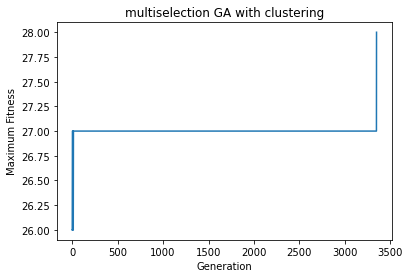

In [14]:
plt.plot(statistics[0],statistics[1])
plt.xlabel('Generation')
plt.ylabel('Maximum Fitness')
plt.title('multiselection GA with clustering')
plt.show()

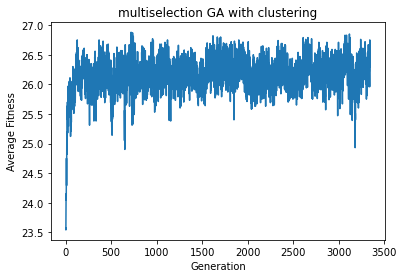

In [15]:
plt.plot(statistics[0],statistics[2])
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title('multiselection GA with clustering')
plt.show()